### Лабораторная работа по методам машинного обучения

1.	Произведите предобработку датасета, если это необходимо.

In [ ]:
%pip install pandas numpy seaborn matplotlib scikit-learn xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
from itertools import cycle
from sklearn.utils.class_weight import compute_class_weight
import time


# Загрузка датасета # Подвыборка (например, 30% данных)
df = pd.read_csv('synthetic_coffee_health_10000.csv').sample(frac=0.1, random_state=42)


# df_sample = df.sample(frac=0.3, random_state=42)
# X = df_sample.drop('Health_Issues', axis=1)
# y = df_sample['Health_Issues']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Просмотр первых строк
print(df.head())

# Информация о датасете
print(df.info())

# Проверка на пропуски
print(df.isnull().sum())

# Проверка на дубликаты
print(df.duplicated().sum())

# Если есть пропуски, заполним их (в данном случае,им, что их нет)
# df.fillna(method='ffill', inplace=True)

# Кодирование категориальных переменных
le = LabelEncoder()

categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Health_Issues', 'Occupation']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Булевы столбцы уже 0/1, но убедимся
df['Smoking'] = df['Smoking'].astype(int)
df['Alcohol_Consumption'] = df['Alcohol_Consumption'].astype(int)

# Удаление ID, так как он не несет информации
df.drop('ID', axis=1, inplace=True)

print(df.head())


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\vladk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
        ID  Age  Gender    Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
6252  6253   66    Male     Norway            2.6        245.9          6.7   
4684  4685   22  Female     Mexico            3.1        293.1          7.6   
1731  1732   30    Male  Australia            3.9        372.4          6.4   
4742  4743   35    Male    Germany            1.0         92.5          5.3   
4521  4522   47    Male      Italy            1.3        119.0          6.9   

     Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
6252          Good  30.1          76          Low                      1.9   
4684          Good  20.4          69          Low                      5.0   
1731          Good  27.5          75          Low                     13.8   
4742          Fair  23.1          71       Medium                      2.4   
4521          Good  28.4          64          Low                    

2.	При помощи матрицы корреляции (или другими известными вам способами) найдите зависимости и визуализируйте их в виде графиков.

    На основе матрицы корреляции можно увидеть зависимости, например, между кофеином и heart_rate, sleep_hours и stress_level и т.д.

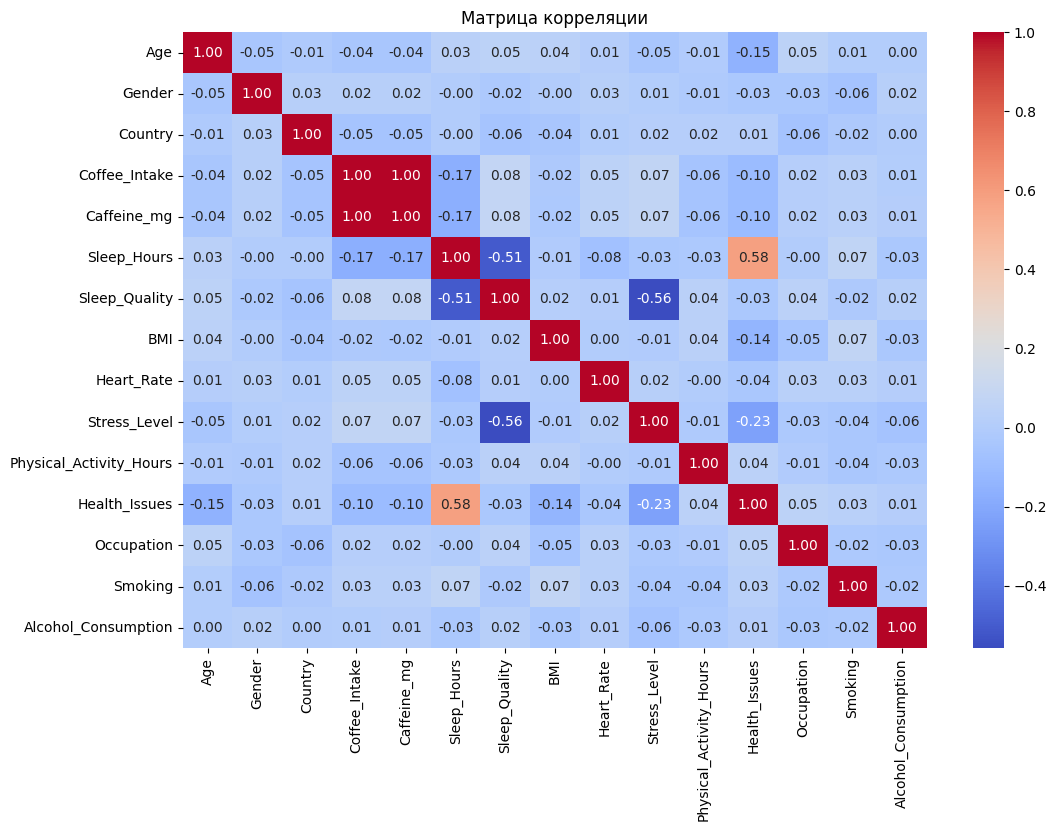

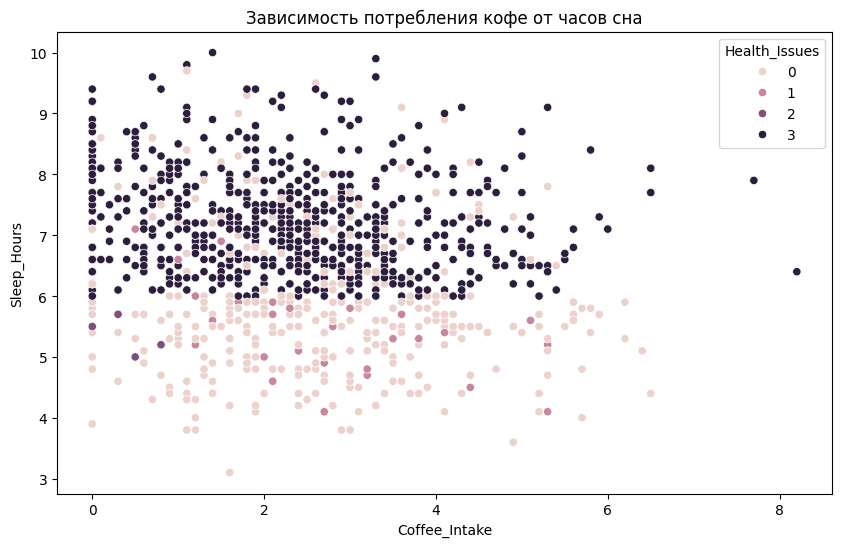

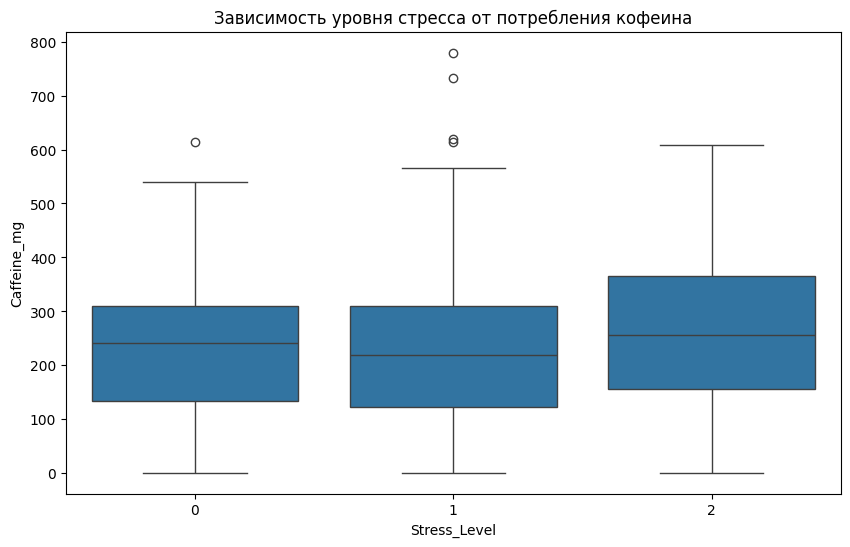

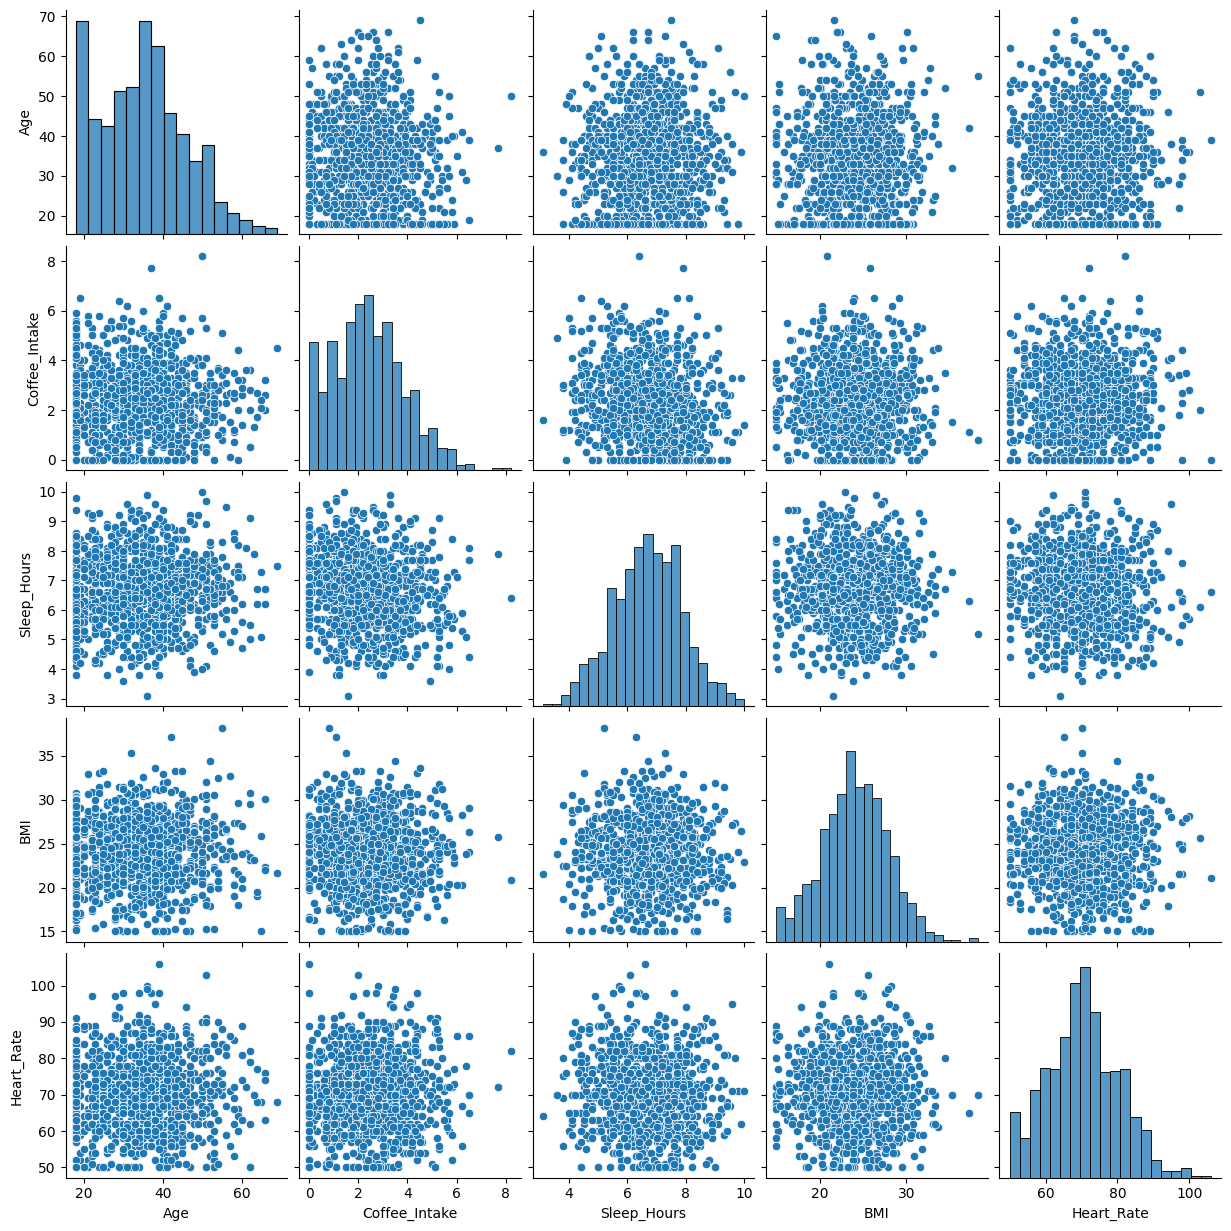

In [ ]:
# Матрица корреляции (только числовые столбцы)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

# Визуализация зависимостей (примеры scatter plots)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Coffee_Intake', y='Sleep_Hours', data=df, hue='Health_Issues')
plt.title('Зависимость потребления кофе от часов сна')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Level', y='Caffeine_mg', data=df)
plt.title('Зависимость уровня стресса от потребления кофеина')
plt.show()

# Дополнительно: pairplot для ключевых переменных
sns.pairplot(df[['Age', 'Coffee_Intake', 'Sleep_Hours', 'BMI', 'Heart_Rate']])
plt.show()

3.	Выберите целевой столбец (как правило это тот параметр, который зависит от остальных параметров и который можно спрогнозировать на основе остальных, к тому же прогноз этого столбца должен представлять какую-то ценность и смысл, например, не логично определять пол человека по количеству времени проведенном с гаджетом, очевидно, что цель исследования должна быть другой.).

    Целевой столбец: Health_Issues (уровень проблем со здоровьем: None, Mild, Moderate, Severe).
Этот параметр зависит от возраста, BMI, сна, потребления кофе и т.д. Прогноз здоровья на основе образа жизни имеет практическую ценность (например, для рекомендаций по кофе).
Это задача многоклассовой классификации.

In [ ]:
# Целевая переменная
target = 'Health_Issues'
X = df.drop(target, axis=1)
y = df[target]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4.	Обучите 2-3 модели машинного обучения известные вам. Примените параметры, которые позволяют избежать переобучение моделей (в каждой модели это разные параметры).

    Обучим 3 модели:

    - Logistic Regression (с регуляризацией C для избежания переобучения).
    - Random Forest (с max_depth и min_samples_leaf).
    - XGBoost (с early_stopping_rounds).

    Используем GridSearchCV для подбора параметров.

In [ ]:
# Настройка стратифицированной кросс-валидации
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Функция для замера времени с поддержкой дополнительных параметров
def train_and_time(model, name, X_train, y_train, X_test, **kwargs):
    start_time = time.time()
    model.fit(X_train, y_train, **kwargs)  # Передаем дополнительные параметры
    elapsed_time = time.time() - start_time
    print(f"{name} обучение завершено за {elapsed_time:.2f} секунд")
    return model

# Модель 1: Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],           # Сила регуляризации (обратная)
    'penalty': ['l2'],           # Тип регуляризации (L2 - Ridge)
    'class_weight': ['balanced'] # Балансировка классов
}
lr_grid = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=500),
    lr_params,
    cv=skf,
    scoring='f1_macro',
    n_jobs=1
)
lr_best = train_and_time(lr_grid, "Logistic Regression", X_train, y_train, X_test)
y_pred_lr = lr_best.best_estimator_.predict(X_test)
y_pred_lr_train = lr_best.best_estimator_.predict(X_train)

# Модель 2: Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],    # Количество деревьев
    'max_depth': [5, 10, 15],          # Максимальная глубина деревьев
    'min_samples_leaf': [1, 2, 4],     # Минимум samples в листе
    'class_weight': ['balanced']       # Балансировка классов
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=skf,
    scoring='f1_macro',
    n_jobs=1
)
rf_best = train_and_time(rf_grid, "Random Forest", X_train, y_train, X_test)
y_pred_rf = rf_best.best_estimator_.predict(X_test)
y_pred_rf_train = rf_best.best_estimator_.predict(X_train)

# Модель 3: XGBoost
xgb = XGBClassifier(
    n_estimators=100,              # Количество деревьев
    max_depth=3,                   # Глубина деревьев
    learning_rate=0.1,             # Скорость обучения
    subsample=0.8,                 # Доля данных для каждого дерева
    colsample_bytree=0.8,          # Доля признаков для каждого дерева
    eval_metric='mlogloss',        # Метрика для ранней остановки
    early_stopping_rounds=10,      # Ранняя остановка
    random_state=42
)
xgb_best = train_and_time(xgb, "XGBoost", X_train, y_train, X_test, 
                          eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb_best.predict(X_test)
y_pred_xgb_train = xgb_best.predict(X_train)

C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in versio

Logistic Regression обучение завершено за 0.90 секунд
Random Forest обучение завершено за 58.88 секунд
XGBoost обучение завершено за 5.45 секунд


5.	На основе метрик качества и ROC-кривой в случае моделей классификации выберите лучшую модель.

    Рассчитаем метрики: Accuracy, F1-score (macro), ROC AUC (one-vs-rest).

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       109
           1       0.39      1.00      0.56        11
           2       1.00      1.00      1.00         1
           3       0.87      0.88      0.88       179

    accuracy                           0.81       300
   macro avg       0.77      0.89      0.79       300
weighted avg       0.83      0.81      0.81       300

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       109
           1       0.75      0.27      0.40        11
           2       0.00      0.00      0.00         1
           3       0.99      1.00      1.00       179

    accuracy                           0.97       300
   macro avg       0.67      0.57      0.59       300
weighted avg       0.96      0.97      0.96       300

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       0.

C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

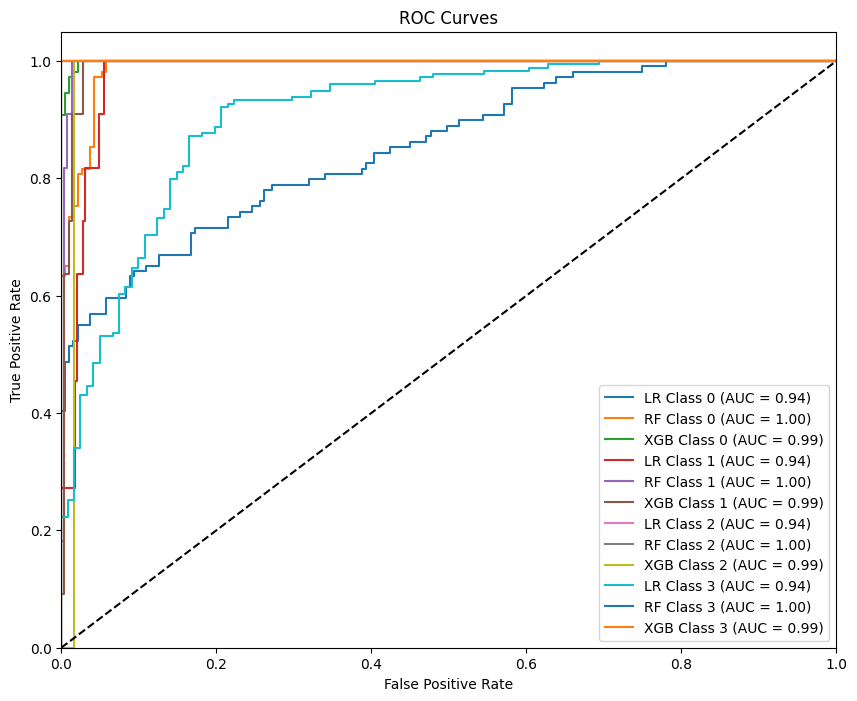

In [71]:
# Бинаризация y для ROC AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Функция для расчета метрик
def evaluate_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    print(classification_report(y_true, y_pred))
    return acc, f1, auc

# Для LR
y_prob_lr = lr_best.predict_proba(X_test)
acc_lr, f1_lr, auc_lr = evaluate_model(y_test, y_pred_lr, y_prob_lr)

# Для RF
y_prob_rf = rf_best.predict_proba(X_test)
acc_rf, f1_rf, auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf)

# Для XGB
y_prob_xgb = xgb.predict_proba(X_test)
acc_xgb, f1_xgb, auc_xgb = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

# Сравнение
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_lr, acc_rf, acc_xgb],
    'F1 Score': [f1_lr, f1_rf, f1_xgb],
    'ROC AUC': [auc_lr, auc_rf, auc_xgb]
})
print(metrics_df)

# ROC-кривые
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr_lr, tpr_lr, _ = roc_curve(y_test_bin[:, i], y_prob_lr[:, i])
    plt.plot(fpr_lr, tpr_lr, label=f'LR Class {i} (AUC = {auc_lr:.2f})')

    fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    plt.plot(fpr_rf, tpr_rf, label=f'RF Class {i} (AUC = {auc_rf:.2f})')

    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGB Class {i} (AUC = {auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

XGBoost — лучшая модель, если приоритет — высокая Accuracy (0.98) и ROC AUC (0.994), а также хорошая производительность на доминирующих классах (0 и 3). Однако она плохо справляется с классом 2 и средне с классом 1.

Random Forest — близка к XGBoost по Accuracy (0.97) и ROC AUC (0.996), но имеет самый низкий F1 Macro (0.59) из-за провала на классе 2 и низкой полноты для класса 1.

Logistic Regression — лучший выбор, если критически важна производительность на редких классах (F1 Macro 0.79), но она уступает по общей точности и ROC AUC.